<a target="_blank" href="https://colab.research.google.com/github/Prindle19/efcoa/blob/main/Sentinel_2_Classification_Dask_ML_KNN_on_GKE.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Colab-only

Install kubectl and Helm

In [ ]:
%cd /tools
!curl -O https://dl.google.com/dl/cloudsdk/channels/rapid/downloads/google-cloud-cli-linux-x86_64.tar.gz > /dev/null 2>&1
!tar -xf google-cloud-cli-linux-x86_64.tar.gz
!gcloud components install -q gke-gcloud-auth-plugin > /dev/null 2>&1
!gcloud components install -q kubectl > /dev/null 2>&1
!curl https://baltocdn.com/helm/signing.asc | gpg --dearmor | sudo tee /usr/share/keyrings/helm.gpg> /dev/null
!sudo apt-get install apt-transport-https --yes > /dev/null 2>&1
!echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/helm.gpg] https://baltocdn.com/helm/stable/debian/ all main" | sudo tee /etc/apt/sources.list.d/helm-stable-debian.list
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install helm > /dev/null 2>&1
%cd /content

/tools
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1699  100  1699    0     0   9660      0 --:--:-- --:--:-- --:--:--  9708
deb [arch=amd64 signed-by=/usr/share/keyrings/helm.gpg] https://baltocdn.com/helm/stable/debian/ all main
/content


In [ ]:
# Colab-only
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Make sure we have a proper version of Dask
!pip install -q --upgrade "dask[complete]==2024.1.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.4 MB/s eta 0:00:00


In [ ]:
# Make sure version printed below is 2024.1.0, if not - restart this session before running next cells
import dask
dask.__version__

'2024.1.0'

In [ ]:
# Set Project, Zone, and Cluster variables
PROJECT="my-project"
ZONE="us-east4-c"
CLUSTER='embeddings-cluster'

In [ ]:
# Set the local machine's gcloud project

!gcloud config set project $PROJECT

Updated property [core/project].


#### 1. Create a new GKE cluster

In [ ]:
%%time

# Create cluster, this takes ~5 min
!gcloud container clusters create $CLUSTER \
    --zone=$ZONE \
    --num-nodes=2 \
    --machine-type=c2-standard-8

Default change: VPC-native is the default mode during cluster creation for versions greater than 1.21.0-gke.1500. To create advanced routes based clusters, please pass the `--no-enable-ip-alias` flag
Note: The Kubelet readonly port (10255) is now deprecated. Please update your workloads to use the recommended alternatives. See https://cloud.google.com/kubernetes-engine/docs/how-to/disable-kubelet-readonly-port for ways to check usage and for migration instructions.
Note: Your Pod address range (`--cluster-ipv4-cidr`) can accommodate at most 1008 node(s).
Created [https://container.googleapis.com/v1/projects/cloud-geographers-internal-gee/zones/us-east4-c/clusters/embeddings-cluster].
To inspect the contents of your cluster, go to: https://console.cloud.google.com/kubernetes/workload_/gcloud/us-east4-c/embeddings-cluster?project=cloud-geographers-internal-gee
kubeconfig entry generated for embeddings-cluster.
NAME                LOCATION    MASTER_VERSION      MASTER_IP      MACHINE_TYP

Inspect your cluster in GKE: https://console.cloud.google.com/kubernetes




#### 2. Deploy Dask to our cluster using Helm

In [ ]:
# Save cluster credentials in ~/.kube/config so that local kubectl and helm commands can use it

!gcloud container clusters get-credentials $CLUSTER --project $PROJECT --zone $ZONE

Fetching cluster endpoint and auth data.
kubeconfig entry generated for embeddings-cluster.


In [ ]:
# Use kubectl to show the nodes that have been deployed

!kubectl get nodes

NAME                                                STATUS   ROLES    AGE     VERSION
gke-embeddings-cluster-default-pool-b0a9dbbd-bbl9   Ready    <none>   2m52s   v1.30.3-gke.1639000
gke-embeddings-cluster-default-pool-b0a9dbbd-fg12   Ready    <none>   2m52s   v1.30.3-gke.1639000


In [ ]:
# Install Dask on the cluster

!helm install --repo https://helm.dask.org \
    --set worker.replicas=16 \
    --set scheduler.serviceType=NodePort --set webUI.serviceType=NodePort --set jupyter.enabled=false \
    my-dask dask > /dev/null

In [ ]:
# Run this command a few times to see the pod VMs are provisioned and in status "Running"

!kubectl get pods -o wide

NAME                                READY   STATUS    RESTARTS   AGE   IP           NODE                                                NOMINATED NODE   READINESS GATES
my-dask-scheduler-5f778c9c4-lrt88   1/1     Running   0          45s   10.16.0.6    gke-embeddings-cluster-default-pool-b0a9dbbd-bbl9   <none>           <none>
my-dask-worker-64dd4775df-2brvw     1/1     Running   0          45s   10.16.0.7    gke-embeddings-cluster-default-pool-b0a9dbbd-bbl9   <none>           <none>
my-dask-worker-64dd4775df-49mj7     1/1     Running   0          45s   10.16.0.13   gke-embeddings-cluster-default-pool-b0a9dbbd-bbl9   <none>           <none>
my-dask-worker-64dd4775df-5j9qx     1/1     Running   0          45s   10.16.1.14   gke-embeddings-cluster-default-pool-b0a9dbbd-fg12   <none>           <none>
my-dask-worker-64dd4775df-5xc45     1/1     Running   0          45s   10.16.1.13   gke-embeddings-cluster-default-pool-b0a9dbbd-fg12   <none>           <none>
my-dask-worker-64dd4775df-7n48c

In [ ]:
# Show which services are running

!kubectl get services

NAME                TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)                       AGE
kubernetes          ClusterIP   34.118.224.1     <none>        443/TCP                       6m1s
my-dask-scheduler   NodePort    34.118.239.207   <none>        8786:31473/TCP,80:32060/TCP   79s


#### 3. Forward ports for Dask Scheduler and Dask UI

In [ ]:
# Run this cell, then open a terminal on the notebook and run the command printed below to forward Dask Scheduler port to localhost:8081

!echo kubectl port-forward $(kubectl get pod --selector="app=dask,component=scheduler,release=my-dask" --output jsonpath='{.items[0].metadata.name}') 8081:8786

kubectl port-forward my-dask-scheduler-5f778c9c4-v5tj9 8081:8786


In [ ]:
# Run this cell, then open a local terminal where you can open a browser window to redirect Dask UI to the local machine port

# Query node name and port to forward for Dask UI
NODE_NAME=!kubectl get pod --selector="app=dask,component=scheduler,release=my-dask" --output jsonpath='{.items[0].spec.nodeName}'
NODE_NAME=NODE_NAME[0]
NODE_PORT=!kubectl get services --output jsonpath='{.items[1].spec.ports[1].nodePort}'
NODE_PORT=NODE_PORT[0]

# Run commands printed below in the local shell to forward Dask UI ports to localhost:8080, create and enter an ssh password when asked

!echo gcloud compute firewall-rules create allow-ssh-ingress-from-iap --direction=INGRESS --action=allow --rules=tcp:22 --source-ranges=35.235.240.0/20
!echo gcloud compute ssh --tunnel-through-iap $NODE_NAME -- -NL 8080:localhost:$NODE_PORT

gcloud compute firewall-rules create allow-ssh-ingress-from-iap --direction=INGRESS --action=allow --rules=tcp:22 --source-ranges=35.235.240.0/20
gcloud compute ssh --tunnel-through-iap gke-embeddings-cluster-default-pool-1afc1ef4-0g9j -- -NL 8080:localhost:31164


#### 4. Test if Dask works

In [ ]:
# Check if local browser can connect to cluster and run jobs

from dask.distributed import Client
client = Client("tcp://127.0.0.1:8081")
client

/usr/local/lib/python3.10/dist-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | Client | Scheduler | Workers |
+-------------+--------+-----------+---------+
| cloudpickle | 2.2.1  | 3.0.0     | 3.0.0   |
| msgpack     | 1.0.8  | 1.0.7     | 1.0.7   |
| numpy       | 1.26.4 | 1.26.3    | 1.26.3  |
| toolz       | 0.12.1 | 0.12.0    | 0.12.0  |
+-------------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.88.0.16:8786' processes=16 threads=128, memory=501.63 GiB>

In [ ]:
# Create a dummy Dask Array

import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
# That array can be used like numpy, but run on Dask cluster

y = x + x.T
z = y[::2, 5000:].mean(axis=1)

z.compute() # observe parallel tasks in the Dask UI

array([1.00006657, 0.99363474, 1.0047817 , ..., 0.99913575, 0.99435166,
       1.00617864])

Check https://docs.dask.org/en/latest/10-minutes-to-dask.html for an intro into Dask

### 5. KMeans example


In [ ]:
# Install Zarr and other dependencies

!pip install -q "dask-ml[complete]" zarr xarray gcsfs pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.3 MB/s eta 0:00:00


In [ ]:
# Make sure to install packages via EXTRA_PIP_PACKAGES or as below, it takes a minute or so to install it on all nodes
from dask.distributed import PipInstall
plugin = PipInstall(packages=["dask-ml[complete]", "gcsfs", "zarr", "xarray"], pip_options=["--upgrade"])
client.register_worker_plugin(plugin)

<ipython-input-30-63fed4168e81>:4: DeprecationWarning: `Client.register_worker_plugin` has been deprecated; please use `Client.register_plugin` instead
  client.register_worker_plugin(plugin)
<ipython-input-30-63fed4168e81>:4: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(plugin)


In [ ]:
# Import Dask ML dependencies

import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [ ]:
# Create random data in the array which will be clustered

X, y = dask_ml.datasets.make_blobs(n_samples=100_000_000,
                                   chunks=10_000_000,
                                   random_state=0,
                                   centers=5)
X = X.persist()
X

dask.array<concatenate, shape=(100000000, 2), dtype=float64, chunksize=(10000000, 2), chunktype=numpy.ndarray>

In [ ]:
# Run KNN on the Dask Cluster

km = dask_ml.cluster.KMeans(n_clusters=5, init_max_iter=2, oversampling_factor=10)
km.fit(X)

/usr/local/lib/python3.10/dist-packages/dask/base.py:1481: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


KMeans(init_max_iter=2, n_clusters=5, oversampling_factor=10)

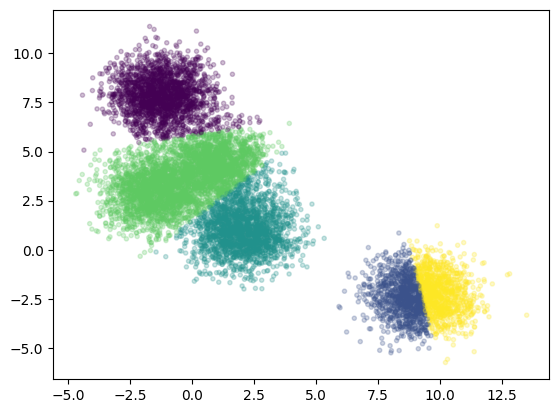

In [ ]:
# Plot a sample (every 10,000 points) to demonstrate the clusters

fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000], cmap='viridis', alpha=0.25);

### 6. Read the Sentinel 2 10m Zarr and Classify on the GKE Dask Cluster


In [ ]:
# Import dependencies and load Sentinel 2 10m Composite Zarr

import gcsfs
import xarray as xr
import zarr
from dask.distributed import Client, progress
import dask_ml.cluster
import matplotlib.pyplot as plt

fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
gcsmap = gcsfs.mapping.GCSMap("gs://cloud-geo-efm-public/s2-composite-10m/", gcs=fs, check=False, create=False)

# Read the dataset
ds = xr.open_zarr(gcsmap)
ds

<xarray.Dataset> Size: 9TB
Dimensions:  (time: 1, lon: 652230, lat: 280102)
Coordinates:
  * lat      (lat) float64 2MB 24.46 24.46 24.46 24.46 ... 49.38 49.38 49.38
  * lon      (lon) float64 5MB -124.9 -124.9 -124.9 ... -66.82 -66.82 -66.82
  * time     (time) datetime64[ns] 8B 2022-01-01
Data variables:
    B1       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B11      (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B12      (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B2       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B3       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B4       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B5       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B6       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B7       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A      (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B9       (time, lon, lat) float32 731GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [ ]:
# Crop the Dataset to the Manasquan, NJ Inlet area

bbox = [-74.09972442,  40.0838885 , -74.02481765,  40.12451048] # 500m buffer

ds_small = ds.sel(
    lat=slice(bbox[1], bbox[3]),
    lon=slice(bbox[0], bbox[2]),
    time='2022-01-01'
)

ds_small

<xarray.Dataset> Size: 18MB
Dimensions:  (lon: 841, lat: 456)
Coordinates:
  * lat      (lat) float64 4kB 40.08 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon      (lon) float64 7kB -74.1 -74.1 -74.1 -74.1 ... -74.03 -74.02 -74.02
    time     datetime64[ns] 8B 2022-01-01
Data variables:
    B1       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B11      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B12      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B2       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B3       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B4       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B5       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B6       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B7       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8A      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B9       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [ ]:
# Convert the DataSet to an Array - using .persist() will ensure
# the results will be kept in distributed memory, rather than returned to the local process as with compute.

da = ds_small.persist().to_array()

# Stack lat and lon dimensions and transpose as KMeans expects input with a shape: (example, feature)
da = da.stack(point=['lat', 'lon']).transpose()
da

<xarray.DataArray (point: 383496, variable: 12)> Size: 18MB
dask.array<transpose, shape=(383496, 12), dtype=float32, chunksize=(383496, 1), chunktype=numpy.ndarray>
Coordinates:
    time      datetime64[ns] 8B 2022-01-01
  * variable  (variable) object 96B 'B1' 'B11' 'B12' 'B2' ... 'B8' 'B8A' 'B9'
  * point     (point) object 3MB MultiIndex
  * lat       (point) float64 3MB 40.08 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon       (point) float64 3MB -74.1 -74.1 -74.1 ... -74.03 -74.02 -74.02
Attributes:
    crs:      EPSG:4326

In [ ]:
# Create 10 classes using Dask ML KNN on the GKE cluster using unsupervised classification

%%time
km = dask_ml.cluster.KMeans(n_clusters=10, init_max_iter=2, oversampling_factor=10)
km.fit(da)

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dask/base.py:1481: UserWarning: Running on a single-machine 

CPU times: user 7.07 s, sys: 1.51 s, total: 8.58 s
Wall time: 2min 28s


KMeans(init_max_iter=2, n_clusters=10, oversampling_factor=10)

In [ ]:
da['predicted_class'] = ('point', km.labels_)

# Unstack the data to restore the original lat/lon dimensions
da = da.unstack('point')
da

<xarray.DataArray (variable: 12, lat: 456, lon: 841)> Size: 18MB
dask.array<reshape, shape=(12, 456, 841), dtype=float32, chunksize=(1, 456, 841), chunktype=numpy.ndarray>
Coordinates:
  * lat              (lat) float64 4kB 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon              (lon) float64 7kB -74.1 -74.1 -74.1 ... -74.02 -74.02
    time             datetime64[ns] 8B 2022-01-01
  * variable         (variable) object 96B 'B1' 'B11' 'B12' ... 'B8' 'B8A' 'B9'
    predicted_class  (lat, lon) int32 2MB dask.array<chunksize=(228, 841), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

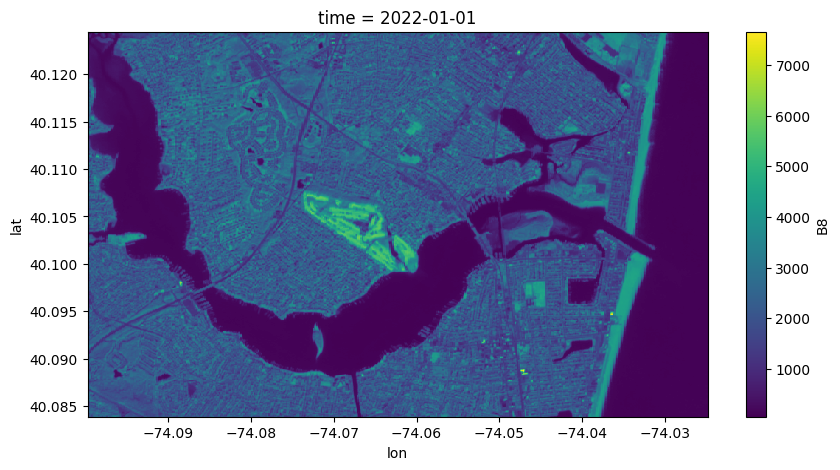

In [ ]:
# For reference, visualize Band 8 of the Sentinel 2 Composite

fig, ax = plt.subplots(figsize=(10, 5))
ds_small.B8.plot(x='lon',y='lat')

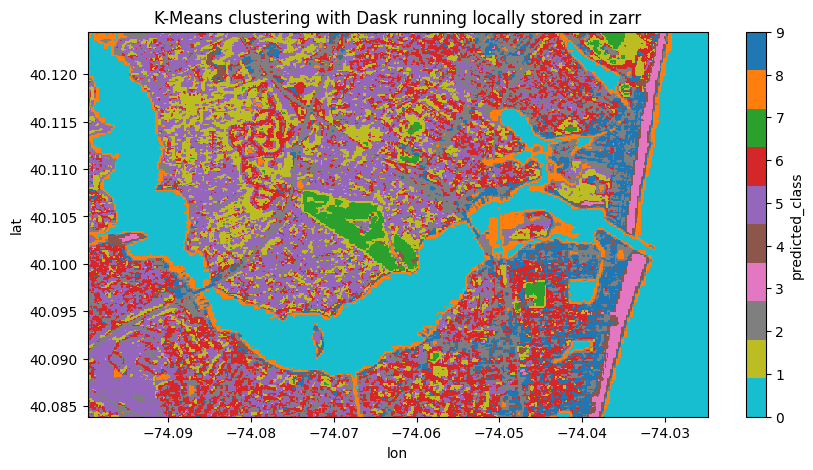

In [ ]:
# Plot the predicted classes

fig, ax = plt.subplots(figsize=(10, 5))
da.predicted_class.plot(ax=ax, add_colorbar=True, x='lon', y='lat', cmap='tab10_r')
ax.set_title("K-Means clustering with Dask running locally stored in zarr")
plt.show()

#### 7. Clean up resources

In [ ]:
# Uninstall Dask
!helm uninstall my-dask

In [ ]:
# Delete the GKE Cluster
%%time

# ~3-4 min
!gcloud container clusters delete --quiet --zone=$ZONE $CLUSTER